# Loan Application Study

## Table of Contents
- [Introduction](#intro)
- [Data Wrangling](#wrangling)
- [Exploratory Data Analysis](#eda)
- [Conclusion of Analysis](#conclusions)
- [Modeling](#modeling)



<a id='introduction'></a>
## Introduction

#### Explanation of the MOS Transistor Behavior (n-channel)

The behavior of an n-channel MOS transistor can be explained as follows:

* When the gate current (Ig) is zero, the drain current (Id), equal to the source current (Is), represents the total current passing through the entire transistor.

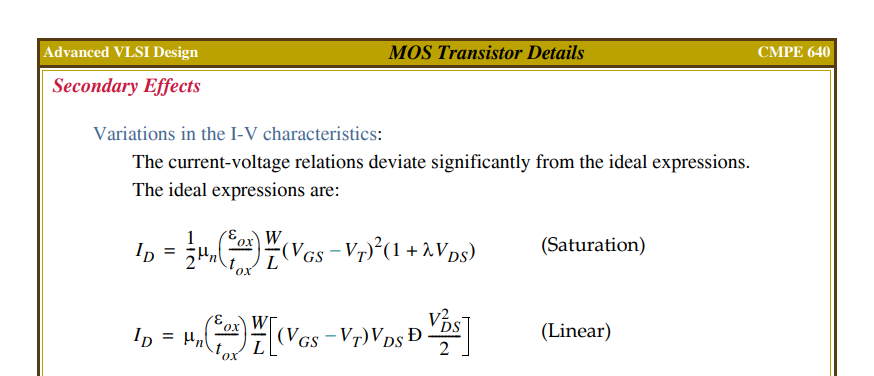

* The value of Id depends on the operating region of the transistor, which is determined by\
the voltages Vgs (gate-source voltage) and Vds (drain-source voltage).
* There are three main regions:


    1. **Cut Off**:
       - If Vgs < Vth (threshold voltage), the transistor is in the "Cut Off" state.
       - Id = 0.

    2. **Triode (Linear)**:
       - If Vgs >= Vth, the transistor turns "ON."
       - In this region, when Vds < Vgs - Vth, the transistor operates in the "Triode" state.
       - Id follows the Linear Law in the image above ☝🏻

    3. **Saturation (Amplifier)**:
       - When Vds > Vgs - Vth in the "ON" state, the transistor is in "Saturation" acting as an **amplifier**.
       - Id follows the Saturation Law in the image above ☝🏻
       
---

### The Challenge 💡
In the complex world of semiconductor physics, predicting transistor current (Id) typically demands numerous features. Our challenge? To harness the power of simplicity. We aim to predict Id using just the following features:

* **vds**: Drain-Source Voltage
* **L(um)**: Length of the transistor (in micrometers)
* **W(um)**: Width of the transistor (in micrometers)
* **drain_length(um)**: Drain length (in micrometers)
* **temperature**: Temperature (in Celsius)
* **vgs**: Gate-Source Voltage
* **vsb**: Source-Body Voltage
    * Vsb can affect the threshold voltage (Vth) and other characteristics.
* **corner**: Categorical corner information
    *  Are used to model the worst-case scenarios of device performance, considering factors like voltage, temperature, and manufacturing process variations.

### Imports & Configrations

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
SEED = 1234

df = pd.read_csv('../Data/simulated_data_nmos.csv')

df.head(2)

,vds,L(um),W(um),drain_length(um),temperature,vgs,vsb,vth,v_pinch_off,lambda(um),id(uA),ig(aA),gm(uS),gmb(uS),ro(Kohm),cgg(aF),cgs(aF),cgd(aF),cdd(aF),cdb(aF),cgb(aF),csb(aF),corner
0,-0.45,8.0,0.84,0.3,27.0,0.0,0.0,0.402306,-0.45,-0.011819,0.034866,0.0,0.659740,0.197561,3181189.42,34032.2445,-28204.1822,-69.122702,88.099279,-4468.20789,-5758.93958,-6638.15046,tt
1,-0.40,8.0,0.84,0.3,27.0,0.0,0.0,0.420865,-0.45,-0.011819,0.009451,0.0,0.196701,0.060563,6552405.05,31291.9536,-24561.0933,-64.892149,80.854021,-3789.70803,-6665.96815,-5628.27847,tt


> Considering only the required features.

In [25]:
df = df[['vds', 'vgs', 'vsb','L(um)', 'W(um)', 'drain_length(um)', 'temperature', 'corner', 'id(uA)']]
df.head(2)

,vds,vgs,vsb,L(um),W(um),drain_length(um),temperature,corner,id(uA)
0,-0.45,0.0,0.0,8.0,0.84,0.3,27.0,tt,0.034866
1,-0.40,0.0,0.0,8.0,0.84,0.3,27.0,tt,0.009451


> Changing the columns names to more easy names

In [36]:
df.rename(columns={
    'L(um)': 'l',
    'W(um)': 'w',
    'drain_length(um)': 'drain_len',
    'id(uA)': 'id'}, inplace=True)
df.head(2)

,vds,vgs,vsb,l,w,drain_len,temperature,corner,id
0,-0.45,0.0,0.0,8.0,0.84,0.3,27.0,tt,0.034866
1,-0.40,0.0,0.0,8.0,0.84,0.3,27.0,tt,0.009451


### Functions we will use

In [26]:
pass

## Data Wrangling

### Data Assessing

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871488 entries, 0 to 871487
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   vds          871488 non-null  float64
 1   vgs          871488 non-null  float64
 2   vsb          871488 non-null  float64
 3   l            871488 non-null  float64
 4   w            871488 non-null  float64
 5   drain_len    871488 non-null  float64
 6   temperature  871488 non-null  float64
 7   corner       871488 non-null  object 
 8   id           871488 non-null  float64
dtypes: float64(8), object(1)
memory usage: 59.8+ MB


> * There are `871488` readings for the transistors.
> 
> * There is no missing values in all features.
> 
> * All features are in the type of `float64` except the `corner` is `string`.

In [54]:
# Checking for duplicated rows
print(f'The existance of duplicated rows is: {df.duplicated().any()}')

The existance of duplicated rows is: False


> There is no duplicated radings.

#### Considering numerical features

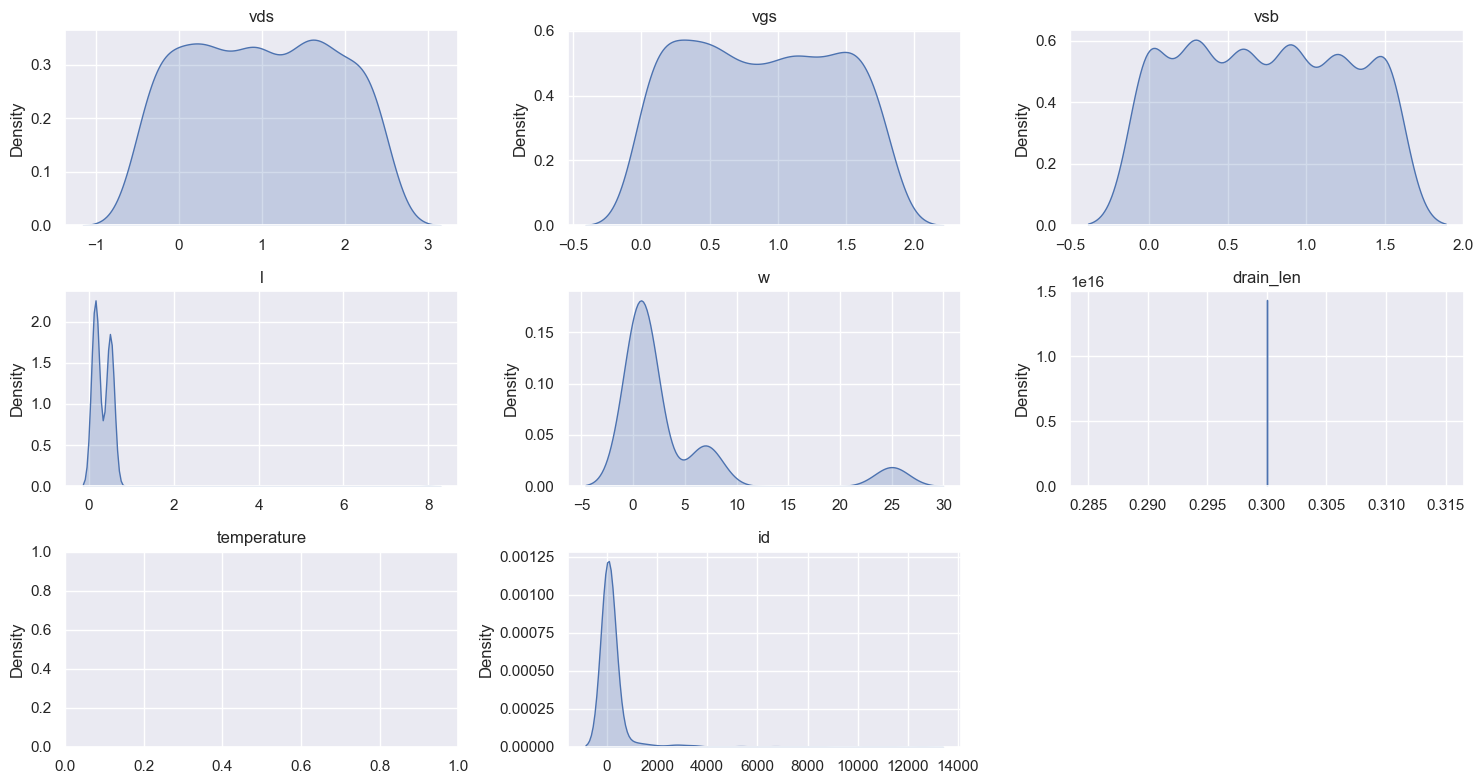

In [58]:
numeric_df = df.select_dtypes(include='number')

plt.figure(figsize=(15, 8))
num_columns = len(numeric_df.columns)

# Creating subplots for each feature's histogram
for i, col in enumerate(numeric_df.columns):
    plt.subplot(3, num_columns // 3 + 1, i + 1)
    sns.kdeplot(numeric_df.sample(1000)[col], shade=True, color='b')
    plt.title(col)
    plt.xlabel("")

plt.tight_layout()

> * **Distribution of the features**
>   - Most of the features exhibit a **Normal Distribution**, suggesting that the data tends to cluster around the mean.
>

> * **Feature Ranges**
>   * The ranges of the features are different. So, we should consdier normalizing them.

> * **Single valued features**
>   * `temperature` & `drain_len` have a single value across the entire dataset, which suggests they may lack discriminatory power for modeling. Consider their relevance for inclusion in the analysis.

> * **Outliers in 'w' Feature**:
>   * Notably, the 'w' feature contains outliers. These values deviate significantly from the majority of data points and may require special consideration in data preprocessing and modeling.

In [68]:
Q1 = df.w.quantile(0.25)
Q3 = df.w.quantile(0.75)
IQR = Q3 - Q1

threshold = 1.5
# Define the lower and upper bounds for outliers
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR

df_with_w_outliers_only = df.query(f'w < {lower_bound} or w > {upper_bound}')
print(f'There are {df_with_w_outliers_only.shape[0]} readings that have width considered outlier!')

There are 205123 readings that have width considered outlier!


#### Considering categorical feature `corner`

In [74]:
# Checking the unique values of the 'corner' feature.
df.corner.value_counts()

fs    177067
tt    177006
sf    176884
ff    176823
ss    163708
Name: corner, dtype: int64

> As they are just 5 unique features, we could One Hot Encoding them.

### Data Cleaning

> First lets drop the single values features

In [76]:
df.drop(columns=['temperature', 'drain_len'], inplace=True)

> We will make some transformation on the data such as, standarizing it and converting the categorical values into numerical values `in the modeling phase after the EDA.`

## Exploratory Data Analysis (EDA)

> **Splitting the data into train & test.**
> 
> The data was split into training and testing sets before EDA to ensure complete test set independence and facilitate parameter tuning without any test set insights.

In [85]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED)
df_train.head()

,vds,vgs,vsb,l,w,corner,id
801381,1.35,0.10,1.5,0.5,0.65,ff,8.561236e-10
770725,-0.45,0.90,0.9,0.5,0.36,ff,3.424492e+01
49247,0.75,1.25,0.9,0.5,7.00,tt,3.680331e+02
537384,0.75,1.15,0.6,0.5,7.00,fs,2.353471e+02
552335,1.10,0.45,0.9,0.5,0.36,fs,3.683220e-06


## Modeling

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay